### *Notebook's goal is breast classification: cancerous (label: 1) and non-cancerous (label: 0)*

# Import lib

In [17]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets
import pytorch_lightning as pl
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, ConcatDataset, random_split
import os
import cv2
import glob
from skimage import io

from skimage import data
from skimage import filters
from skimage.color import rgb2gray
from skimage.io import imread

# EDA

In [19]:
df = pd.read_csv('./data/info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [20]:
df['CLASS'] = [0 if x == 'NORM' else 1 for x in df['CLASS']]

In [21]:
df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,1,B,535.0,425.0,197.0
1,mdb002,G,1,B,522.0,280.0,69.0
2,mdb003,D,0,NaN,NaN,NaN,NaN
3,mdb004,D,0,NaN,NaN,NaN,NaN
4,mdb005,F,1,B,477.0,133.0,30.0


In [22]:
labels = df.drop_duplicates(subset=['REFNUM'])['CLASS']

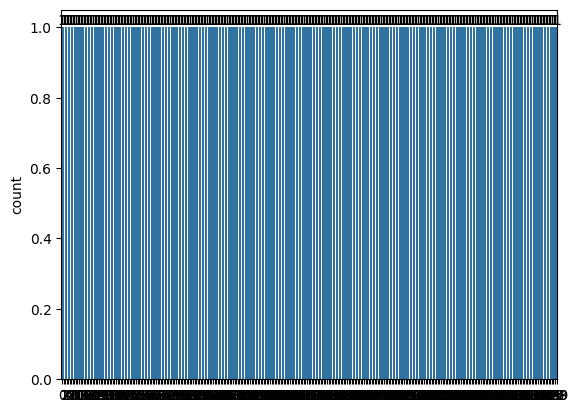

In [23]:
ax = sns.countplot(labels);
ax.bar_label(ax.containers[0]);

In [24]:
labels.head(), np.array(labels).shape

(0    1
 1    1
 2    0
 3    0
 4    1
 Name: CLASS, dtype: int64,
 (322,))

In [25]:
# haha = []
# for i in glob.glob("/kaggle/input/mias-roi-mammography/Cancer/*"):
#     haha.append(i)
# for j in glob.glob("/kaggle/input/mias-roi-mammography/Normal/*"):
#     haha.append(j)
# haha = sorted(haha, key=lambda x: int(x[45:48]))
# len(haha)

In [26]:
# df = pd.read_csv("/kaggle/input/mias-roi-mammography/description.csv")
# df = df.drop_duplicates(subset=['Refnum'])
# df = df[["Refnum", "Cancer", "Path"]]
# df["Path"] = haha
# df.to_csv("description.csv")

### Create metadata file

In [27]:
# path='/kaggle/input/mias-png/'
# images_path=[]
# all_imgs = sorted(os.listdir(path))
# for i in all_imgs:
#     images_path.append('/kaggle/input/mias-png/' + i)
    
# File output
# d = {'Images path': images_path, 'Labels': labels}
# pd.DataFrame(d).to_csv('metadata.csv')

# MIAS Dataset

In [53]:
class MIAS(Dataset):
    def __init__(self, csv_file, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = "./data/images/" + self.img_labels["Path"][idx]
        img = cv2.imread(img_path, 0)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img)
        label = self.img_labels["Cancer"][idx]
        if self.transform:
            image = self.transform(img_clahe)
        return image, label


labels_path = "./data/description.csv"
transform1 = transforms.Compose(
    [  # transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(1),
        transforms.RandomRotation(10),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)
transform2 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)


transformed = MIAS(labels_path, transform=transform1)
original = MIAS(labels_path, transform=transform2)
full_dataset = ConcatDataset([transformed, original])

### Show image

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


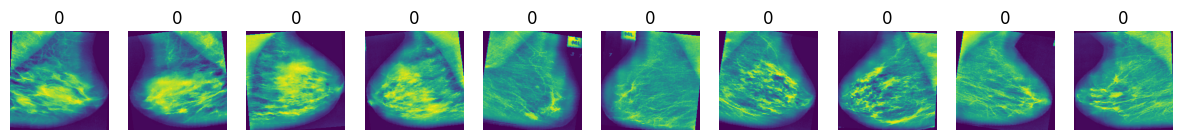

In [54]:
plt.figure(figsize=(15, 15))
for idx, (img, label) in enumerate(full_dataset):
    #print(img.shape) 1 224 224 
    #print(img.permute(1, 2, 0).shape, label) 224 224 1
    plt.subplot(1,10,idx+1)
    plt.imshow(img.squeeze())
    plt.axis('off')
    plt.title(label)
    if idx == 9:
        break

### DataLoader

In [55]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [56]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

[ WARN:0@907.553] global loadsave.cpp:248 findDecoder imread_('mdb072.png'): can't open/read file: check file path/integrity


TypeError: pic should be PIL Image or ndarray. Got <class 'NoneType'>

### DataModule

In [34]:
class Datamodule(pl.LightningDataModule):
    def __init__(self, batch_size: int, train_set, test_set=None, validate_set=None):
        super().__init__()
        self.train_set = train_set
        self.test_set = test_set
        self.validate_set = validate_set
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.validate_set, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set,batch_size=self.batch_size)

# Model

In [57]:
class CNN(pl.LightningModule):
    def __init__(self, width:int=227, height:int=227):
        super().__init__()
        def layer(input_channel: int, 
                  output_channel: int, 
                  kernel_size_conv: int=3, 
                  padding: str='same', 
                  stride_conv: int=1, 
                  kernel_size_maxpool: int=2, 
                  stride_maxpool: int=2,
                  normalize=True,
                  maxpool=True):
            layers = [nn.Conv2d(input_channel, 
                                output_channel, 
                                kernel_size_conv,
                                stride_conv,
                                padding
                                )]
            if normalize:
                layers.append(nn.BatchNorm2d(output_channel))
            layers.append(nn.ReLU())
            if maxpool:
                layers.append(nn.MaxPool2d(kernel_size=kernel_size_maxpool, 
                                           stride=stride_maxpool))
            return layers
        
        self.model = nn.Sequential(
                        *layer(input_channel=1,
                               output_channel=8),
                        *layer(input_channel=8,
                               output_channel=16),
                        *layer(input_channel=16,
                               output_channel=32,
                               maxpool=False)
                    )
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear((width//4) * (height//4) * 32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.model(x.float())
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)   
        x = self.softmax(x)
        return x

In [58]:
summary(CNN(width=227, height=227).cuda().float(), (1, 227, 227))

AssertionError: Torch not compiled with CUDA enabled

In [36]:
class FullModel(pl.LightningModule):
    def __init__(self, 
                 lr: float, 
                 total_steps: int,
                 width:int=227,
                 height:int=227
                 ):
        super().__init__()
        self.lr = lr
        self.model = CNN(width=width, height=height)
        self.criterion = nn.CrossEntropyLoss()
        self.total_steps = total_steps
        self.save_hyperparameters()
        self.dem = 0
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, betas=(0.9, 0.98), weight_decay=1e-4)
        #optimizer = torch.optim.SGD(model.parameters(), lr=self.lr)
        #optimizer = torch.optim.RMSprop(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.lr, total_steps=self.total_steps, verbose=False,
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "step",  # or 'epoch'
            "frequency": 1,
        }
        return [optimizer], [scheduler]
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        img, labels = batch
        outputs = self.model(img)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss.item())
        #Accuracy
        output = torch.argmax(outputs, dim=1)
        correct = (output == labels).float().sum()
        self.log("train_loss", loss.item())
        self.log("train_acc", correct/len(labels))
        return loss

    def validation_step(self, batch, batch_idx):
        img, labels = batch
        outputs = self.model(img)
        loss = self.criterion(outputs, labels)
        #Accuracy
        output = torch.argmax(outputs, dim=1)
        correct = (output == labels).float().sum()
        self.log("val_loss", loss.item())
        self.log("val_acc", correct/len(labels))
        return loss

    def test_step(self, batch, batch_idx):
        img, labels = batch
        outputs = self.model(img)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss.item())
        self.log("test_loss", loss.item())
        self.log("test_acc", acc.item())
        return loss

In [72]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")
!wandb login $secret_value_0

ModuleNotFoundError: No module named 'kaggle_secrets'

In [62]:
dm = Datamodule(64, train_dataset, test_dataset, test_dataset)

In [63]:
max_epochs = 24
lr = 0.00015
total_step = len(dm.train_dataloader()) * max_epochs
model = FullModel(lr, total_step, width = 227, height = 227)

In [73]:
wandb_logger = pl.loggers.WandbLogger(
    project="BREAST-CANCER", name='MIAS_CNN_e', log_model="all"
)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[lr_monitor],
    max_epochs=max_epochs,
    accelerator="auto",
    log_every_n_steps=1,
    check_val_every_n_epoch=5,
)

trainer.fit(model, datamodule=dm)

ModuleNotFoundError: DistributionNotFound: The 'wandb>=0.12.10' distribution was not found and is required by the application. HINT: Try running `pip install -U 'wandb>=0.12.10'`

In [65]:
trainer.save_checkpoint("model_ver3.ckpt")

NameError: name 'trainer' is not defined

In [ ]:
trainer.validate(model, dataloaders=dm)

model.eval()
